In [1]:
import numpy as np
import os
import torch
from misc.example_helper import *
import importlib
import processing
import models
%load_ext autoreload
%autoreload 2
importlib.reload(processing)
importlib.reload(models)
from processing.data_manager import SHREDDataManager
from processing.parametric_data_manager import ParametricSHREDDataManager
from models.shred_models import SHRED
from models.shred_models import evaluate

In [2]:
import os

# Initialize SHREDDataManager
manager = SHREDDataManager(
    lags = 20,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
    compression = True,
    time=np.arange(0, 2000),
    method="all"
)


# # Add data to manager (no sensors)
input_folder = "data14fields_npz"
for filename in os.listdir(input_folder):
    if filename.endswith(".npz") and (filename == 'ne_3D.npz' or filename == 'EfX_3D.npz'):
        file_path = os.path.join(input_folder, filename)
        manager.add_field(
            data=file_path,
            id = str(os.path.splitext(filename)[0]),
            # random_sensors=3,
        )
        print(f"Processed: {filename}")

# Add data to manager (with sensors)
filename = 'ni_3D.npz'
file_path = os.path.join(input_folder, filename)
ni_3D = np.load(file_path)
ni_3D = ni_3D[ni_3D.files[0]]
mobile_sensors = [
    perimeter_walk(height = ni_3D.shape[1], width = ni_3D.shape[2], timesteps = ni_3D.shape[0], clockwise=True),
    perimeter_walk(height = ni_3D.shape[1], width = ni_3D.shape[2], timesteps = ni_3D.shape[0], clockwise=False)
]
manager.add_field(
    data=ni_3D,
    random_sensors=3,
    # stationary_sensors=[(7, 9), (0,0)],
    # mobile_sensors=mobile_sensors,
    id = str(os.path.splitext(filename)[0])
)


Processed: ne_3D.npz
Processed: EfX_3D.npz


In [5]:
manager.val_dataset

In [6]:
manager.input_summary

,field id,sensor id,sensor type,location/trajectory
0,ni_3D,ni_3D-0,stationary (randomly selected),"(32, 25)"
1,ni_3D,ni_3D-1,stationary (randomly selected),"(248, 147)"
2,ni_3D,ni_3D-2,stationary (randomly selected),"(164, 152)"


In [222]:
manager.sensor_measurements

,time,ni_3D-0,ni_3D-1,ni_3D-2
0,0,5.245500e+16,4.466700e+16,5.069800e+16
1,1,5.369300e+16,4.463000e+16,5.099200e+16
2,2,5.583700e+16,4.521100e+16,5.132500e+16
3,3,5.745700e+16,4.859100e+16,5.222300e+16
4,4,5.964000e+16,5.308500e+16,5.246100e+16
...,...,...,...,...
1995,1995,1.172600e+17,1.649600e+17,9.778500e+16
1996,1996,1.189600e+17,1.802300e+17,1.015300e+17
1997,1997,1.304800e+17,1.702900e+17,1.048300e+17
1998,1998,1.411600e+17,1.525400e+17,1.059200e+17


In [223]:
# Get train/val/test datasets
train_set, val_set, test_set = manager.preprocess()

# Print dataset shapes
print('Data Shapes:')
print ('Reconstructor Data')
print('train X:', train_set.reconstructor_dataset.X.shape)
print('train Y:', train_set.reconstructor_dataset.Y.shape)
print('val X:', val_set.reconstructor_dataset.X.shape)
print('val Y:', val_set.reconstructor_dataset.Y.shape)
print('test X:', test_set.reconstructor_dataset.X.shape)
print('test Y:', test_set.reconstructor_dataset.Y.shape)

print ('Predictor Data')
print('train X:', train_set.predictor_dataset.X.shape)
print('train Y:', train_set.predictor_dataset.Y.shape)
print('val X:', val_set.predictor_dataset.X.shape)
print('val Y:', val_set.predictor_dataset.Y.shape)
print('test X:', test_set.predictor_dataset.X.shape)
print('test Y:', test_set.predictor_dataset.Y.shape)

print ('Sensor Forecaster Data')
print('train X:', train_set.sensor_forecaster_dataset.X.shape)
print('train Y:', train_set.sensor_forecaster_dataset.Y.shape)
print('val X:', val_set.sensor_forecaster_dataset.X.shape)
print('val Y:', val_set.sensor_forecaster_dataset.Y.shape)
print('test X:', test_set.sensor_forecaster_dataset.X.shape)
print('test Y:', test_set.sensor_forecaster_dataset.Y.shape)

Data Shapes:
Reconstructor Data
train X: torch.Size([1600, 21, 3])
train Y: torch.Size([1600, 150])
val X: torch.Size([200, 21, 3])
val Y: torch.Size([200, 150])
test X: torch.Size([200, 21, 3])
test Y: torch.Size([200, 150])
Predictor Data
train X: torch.Size([1600, 21, 3])
train Y: torch.Size([1600, 150])
val X: torch.Size([200, 21, 3])
val Y: torch.Size([200, 150])
test X: torch.Size([200, 21, 3])
test Y: torch.Size([200, 150])
Sensor Forecaster Data
train X: torch.Size([1600, 21, 3])
train Y: torch.Size([1600, 3])
val X: torch.Size([200, 21, 3])
val Y: torch.Size([200, 3])
test X: torch.Size([200, 21, 3])
test Y: torch.Size([200, 3])


In [224]:
# initialize SHRED
shred = SHRED(sequence='LSTM', decoder='SDN')
# fit SHRED
val_errors = shred.fit(train_set, val_set, num_epochs=100, patience=100, verbose=True)


Fitting Reconstructor...


Epoch 1/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 23/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 24/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 25/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 26/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 27/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 28/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 29/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 30/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 31/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 32/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 33/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 34/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 35/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 36/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 37/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 38/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 39/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 40/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 41/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 42/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 43/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 44/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 45/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 46/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 47/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 48/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 49/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 50/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 51/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 52/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 53/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 54/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 55/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 56/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 57/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 58/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 59/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 60/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 61/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 62/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 63/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 64/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 65/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 66/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 67/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 68/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 69/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 70/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 71/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 72/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 73/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 74/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 75/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 76/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 77/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 78/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 79/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 80/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 81/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 82/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 83/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 84/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 85/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 86/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 87/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 88/100:   0%|          | 0/25 [00:00<?, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 97/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 98/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 99/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 100/100:   0%|          | 0/25 [00:00<?, ?batch/s]


Fitting Predictor...


Epoch 1/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 23/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 24/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 25/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 26/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 27/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 28/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 29/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 30/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 31/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 32/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 33/100:   0%|          | 0/25 [00:00<?, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 42/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 43/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 44/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 45/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 46/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 47/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 48/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 49/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 50/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 51/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 52/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 53/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 54/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 55/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 56/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 57/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 58/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 59/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 60/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 61/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 62/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 63/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 64/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 65/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 66/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 67/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 68/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 69/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 70/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 71/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 72/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 73/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 74/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 75/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 76/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 77/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 78/100:   0%|          | 0/25 [00:00<?, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 87/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 88/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 89/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 90/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 91/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 92/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 93/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 94/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 95/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 96/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 97/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 98/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 99/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 100/100:   0%|          | 0/25 [00:00<?, ?batch/s]


Fitting Sensor Forecaster...


Epoch 1/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/25 [00:00<?, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 31/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 32/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 33/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 34/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 35/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 36/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 37/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 38/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 39/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 40/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 41/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 42/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 43/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 44/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 45/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 46/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 47/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 48/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 49/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 50/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 51/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 52/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 53/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 54/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 55/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 56/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 57/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 58/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 59/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 60/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 61/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 62/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 63/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 64/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 65/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 66/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 67/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 68/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 69/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 70/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 71/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 72/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 73/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 74/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 75/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 76/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 77/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 78/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 79/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 80/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 81/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 82/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 83/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 84/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 85/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 86/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 87/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 88/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 89/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 90/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 91/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 92/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 93/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 94/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 95/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 96/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 97/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 98/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 99/100:   0%|          | 0/25 [00:00<?, ?batch/s]

Epoch 100/100:   0%|          | 0/25 [00:00<?, ?batch/s]

In [225]:
evaluate(shred = shred, test_dataset=test_set, data_manager=manager, uncompress=False) # not the same L2 as validation because performs unscaling

,ne_3D,EfX_3D,ni_3D
reconstruction,0.563792,0.781022,0.632220
prediction,0.981474,1.119781,1.018856
forecast,0.964189,1.087778,0.995390
sensor_forecast,0.071706,NaN,NaN


In [226]:
reconstruction = shred.reconstruct(test_set.reconstructor_dataset.X).detach().cpu().numpy()

In [227]:
reconstruction.shape

(200, 150)

In [228]:
reconstruction = shred.reconstruct(test_set.reconstructor_dataset.X).detach().cpu().numpy()
dataset_dict_recon = manager.postprocess(reconstruction, uncompress = True, method = 'reconstructor')
true_dataset_dict_recon = manager.postprocess(test_set.predictor_dataset.Y.cpu().numpy(),  uncompress = True, method = 'reconstructor')

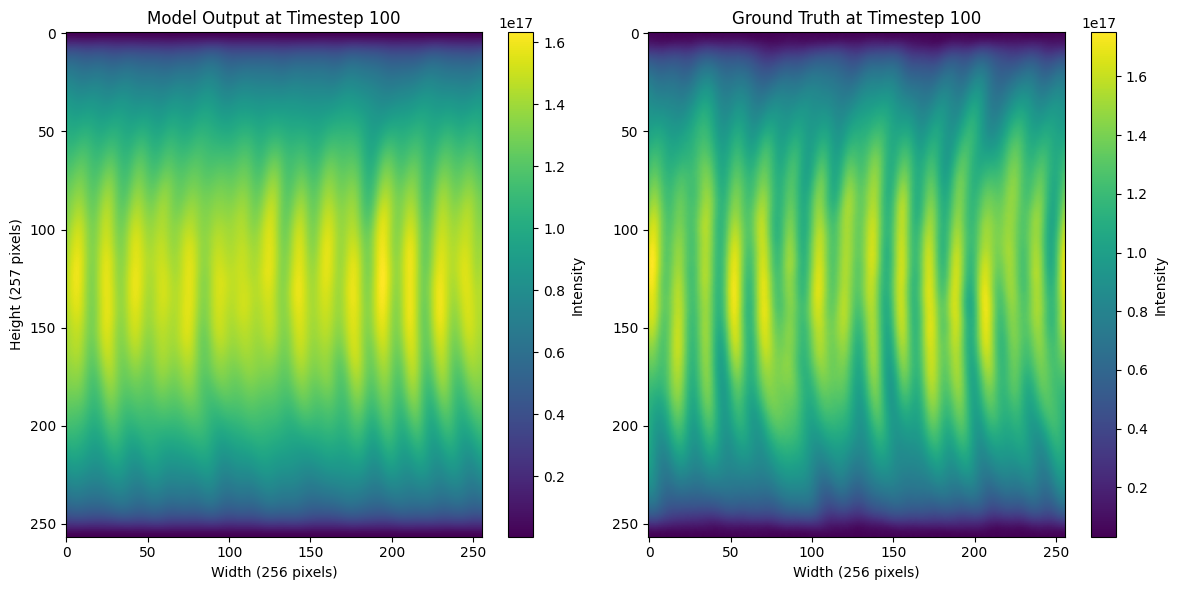

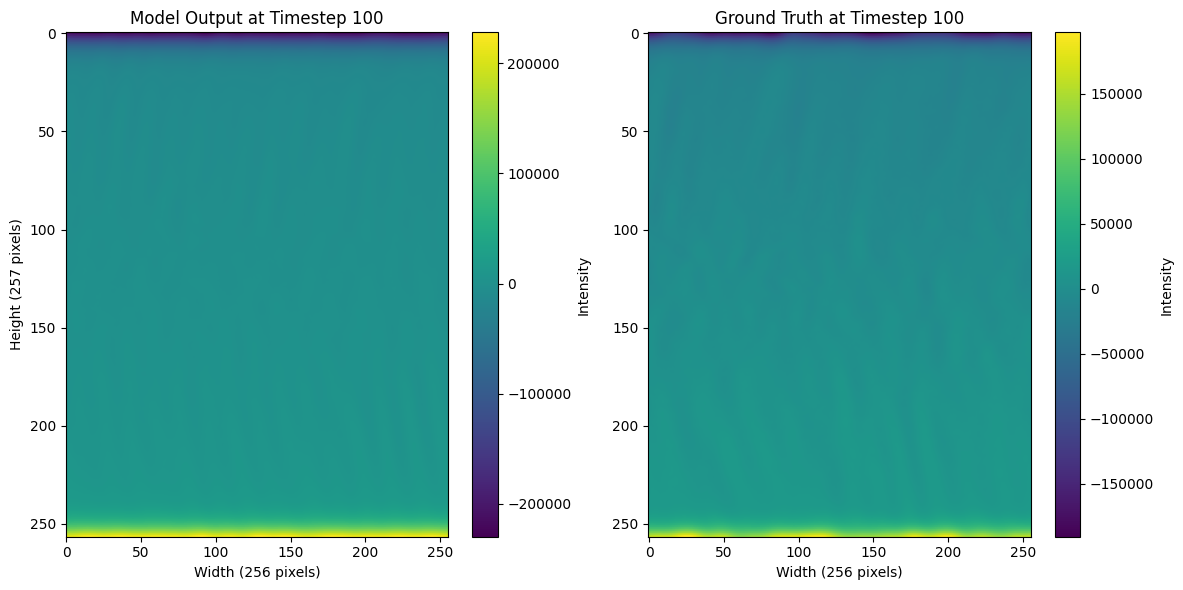

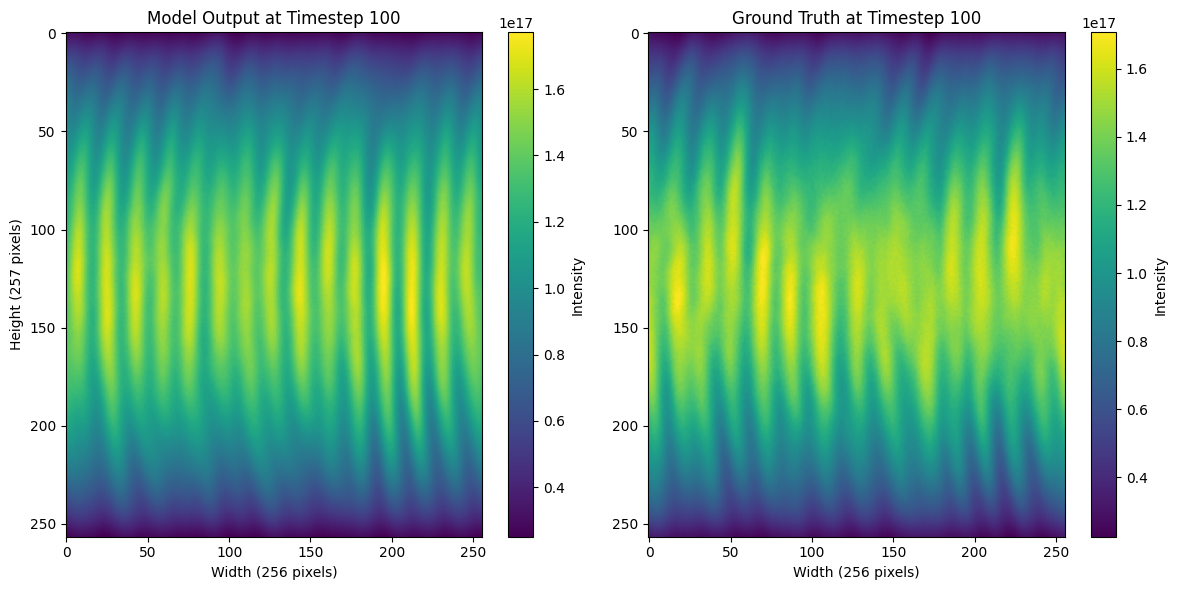

In [229]:
t = 100
for key in dataset_dict_recon.keys():
    plot_frame_comparison(dataset_dict_recon[key], true_dataset_dict_recon[key], timestep=t)  # Plot frame at timestep 100

In [230]:
prediction = shred.predict(test_set.predictor_dataset.X).detach().cpu().numpy()
dataset_dict_prediction = manager.postprocess(prediction, method = 'predictor')
true_dataset_dict_prediction = manager.postprocess(test_set.predictor_dataset.Y.cpu().numpy(), method = 'predictor')

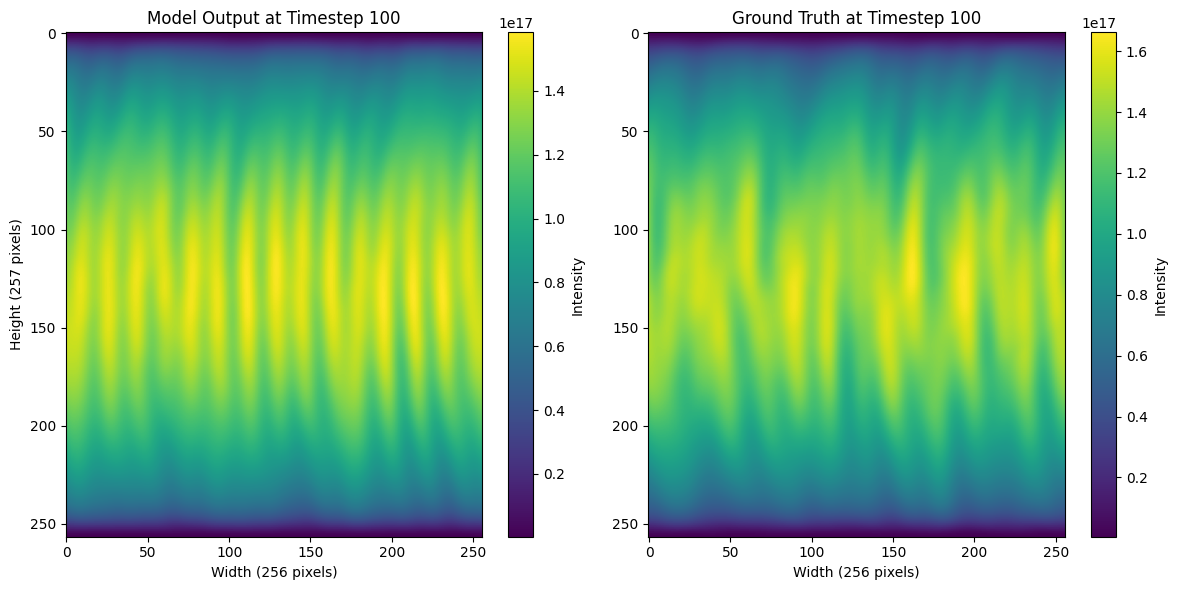

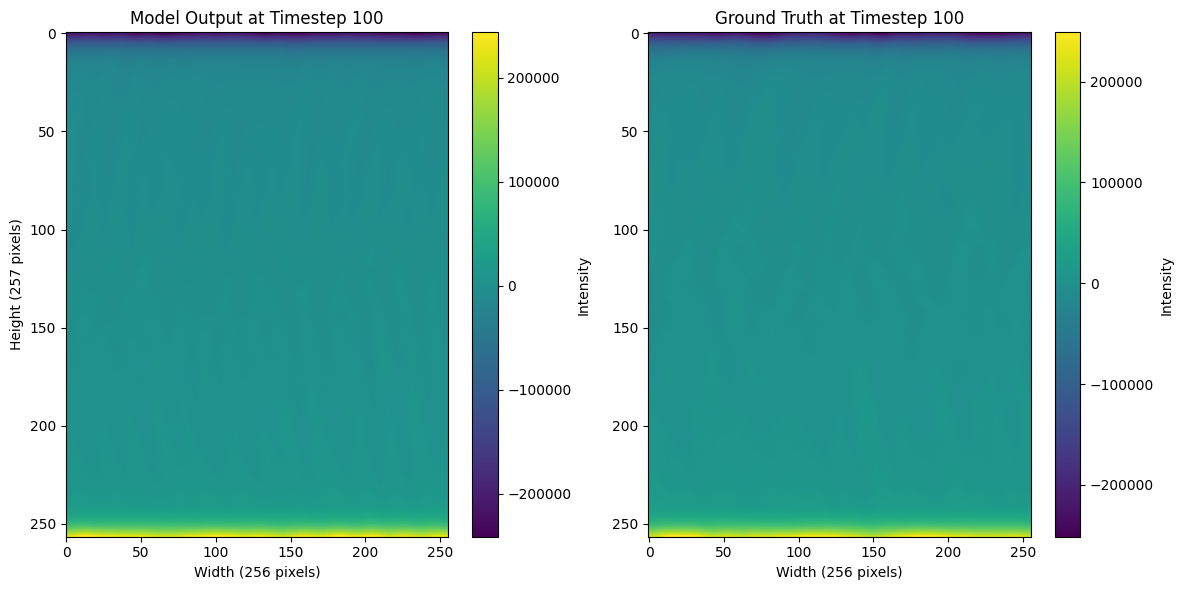

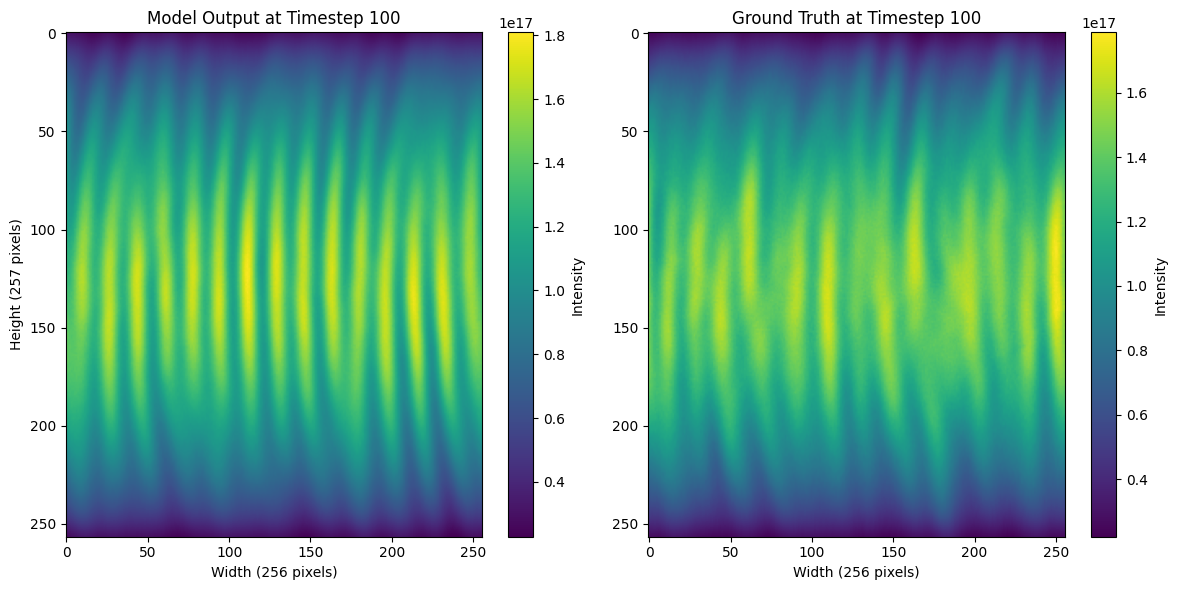

In [231]:
t = 100
for key in dataset_dict_prediction.keys():
    plot_frame_comparison(dataset_dict_prediction[key], true_dataset_dict_prediction[key], timestep=t)  # Plot frame at timestep 100

In [232]:
sensor_measurements_for_prediction_dict['sensor_measurements'][-1]

array([3.7248e+16, 3.4050e+16, 6.2040e+16])

In [233]:
test_set.sensor_forecaster_dataset.Y[-1]

tensor([0.5817, 0.5323, 0.4808], device='cuda:0')

In [234]:
### Pure Forecast ###
# sensor_measurements_for_prediction_dict = manager.generate_X(start = 1998, end = 2020, forecaster=shred.sensor_forecaster, method = 'predictor')
sensor_measurements_for_prediction_dict = manager.generate_X(start = 0, end = 2000, method = 'predictor', forecaster = shred.sensor_forecaster)
sensor_measurements_for_prediction = sensor_measurements_for_prediction_dict['X']
#####################
print('Generate_X:', sensor_measurements_for_prediction.shape)
forecast_out = shred.predict(sensor_measurements_for_prediction)
print('Prediction:', forecast_out.shape)
forecast_post_process = manager.postprocess(forecast_out, uncompress = True, method = 'predictor')
print('Post-process',forecast_post_process['ni_3D'].shape)
print()

TypeError: SHREDDataProcessor.generate_X() got an unexpected keyword argument 'sensor_measurements'

In [ ]:
manager.data_processors[2].sensor_scaler

In [ ]:
sensor_measurements_for_prediction_dict['sensor_measurements'][0:21]

In [ ]:
sensor_measurements_for_prediction

In [ ]:
### No Forecast, fill gaps with zeros ###
sensor_measurements_for_prediction_dict = manager.generate_X(start = 2000, end = 2020, method = 'predictor', forecaster = shred.sensor_forecaster)
sensor_measurements_for_prediction = sensor_measurements_for_prediction_dict['X']
#####################
print('Generate_X:', sensor_measurements_for_prediction.shape)
forecast_out = shred.predict(sensor_measurements_for_prediction)
print('Prediction:', forecast_out.shape)
forecast_post_process = manager.postprocess(forecast_out, uncompress = True, method = 'predictor')
print('Post-process',forecast_post_process['ni_3D'].shape)
print()

In [ ]:
sensor_measurements_dict

In [ ]:
# Generate X only from data provided
sensor_measurements = manager.sensor_measurements.to_numpy()[:,1:]

# print('sensor_measurements', sensor_measurements.shape)
# sensor_measurements_generate_X = manager.generate_X(measurements=sensor_measurements, method = 'predictor')
# print('generate_X',sensor_measurements_generate_X.shape)


In [ ]:
# Generate X from data provided and historical data and sensor_forecaster, start_time, end_time 
sensor_measurements = manager.sensor_measurements.to_numpy()[:,1:]
print('sensor_measurements', sensor_measurements.shape)
sensor_measurements_generate_X_dict = manager.generate_X(measurements=sensor_measurements, method = 'predictor')
sensor_measurements_generate_X = sensor_measurements_generate_X_dict['X']
print('generate_X',sensor_measurements_generate_X.shape)


In [ ]:
a = train_set.predictor_dataset.X
b = sensor_measurements_generate_X[0:1600]
if torch.allclose(a, b, rtol=1e-05, atol=1e-08):
    print("Tensors are about equal!")
else:
    print("Tensors are different.")

In [ ]:
### No Forecast ###
sensor_measurements_for_prediction_dict = manager.generate_X(start = 2000, end = 2099, sensor_measurements = sensor_measurements[0:100],
                                                        time = np.arange(2000,2100), forecaster=shred.sensor_forecaster,
                                                        method = 'predictor')
sensor_measurements_for_prediction = sensor_measurements_for_prediction_dict['X']
#####################
print('Generate_X:', sensor_measurements_for_prediction.shape)
forecast_out = shred.predict(sensor_measurements_for_prediction)
print('Prediction:', forecast_out.shape)
forecast_post_process = manager.postprocess(forecast_out, uncompress = True, method = 'predictor')
print('Post-process',forecast_post_process['ni_3D'].shape)
print()

In [ ]:
sensor_measurements_for_prediction_dict['sensor_measurements']

In [ ]:
train_set.sensor_forecaster_dataset.Y

In [ ]:
sensor_measurements_for_prediction[0,-1,:]

In [ ]:
### No Forecast ###
sensor_measurements_for_prediction_dict = manager.generate_X(start = 2000, end = 2099, measurements = sensor_measurements[0:100],
                                                        time = np.arange(2000,2100), forecaster=shred.sensor_forecaster,
                                                        method = 'predictor', return_sensor_measurements = True)
sensor_measurements_for_prediction = sensor_measurements_for_prediction_dict['X']
#####################
print('Generate_X:', sensor_measurements_for_prediction.shape)
forecast_out = shred.predict(sensor_measurements_for_prediction)
print('Prediction:', forecast_out.shape)
forecast_post_process = manager.postprocess(forecast_out, uncompress = True, method = 'predictor')
print('Post-process',forecast_post_process['ni_3D'].shape)
print()

In [ ]:
test_set.sensor_forecaster_dataset.X

In [ ]:
sensor_measurements_for_prediction

In [ ]:
### No Forecast ###
sensor_measurements_for_prediction = manager.generate_X(start = 2000, end = 2020, forecaster=shred.sensor_forecaster, method = 'predictor')
#####################
print('Generate_X:', sensor_measurements_for_prediction.shape)
forecast_out = shred.predict(sensor_measurements_for_prediction)
print('Prediction:', forecast_out.shape)
forecast_post_process = manager.postprocess(forecast_out, uncompress = True, method = 'predictor')
print('Post-process',forecast_post_process['ni_3D'].shape)
print()

In [ ]:
# fake_new_measurements = manager.generate_X(measurements=all_sensor_measurements)

# print(test_set.forecaster.Y.shape)
# fake = test_set.forecaster.Y[0:5,:]
# print(fake.shape)

# time = np.arange(2020,2221)
# fake = test_set.sensor_forecaster_dataset.Y[0:len(time),:]

# sensor_measurements_for_prediction = manager.generate_X(start = 2006, end = 2020, measurements = fake, time = time, forecaster=shred._sensor_forecaster)